In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
# TensorFlow and tf.keras
import tensorflow as tf
print(tf.__version__)
import random
random.seed(12345)
tf.random.set_seed(12345)

import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib

2.6.0


In [2]:
train_data_dir = pathlib.Path("Covid-Model_dataset/Train")
test_data_dir = pathlib.Path("Covid-Model_dataset/Test")

In [3]:
image_count = len(list(train_data_dir.glob('*/*')))
print(image_count)

320


In [4]:
batch_size = 32
img_height = 512
img_width = 512

In [5]:
!rm -rf Covid-Model_dataset/Train/.ipynb_checkpoints
!rm -rf Covid-Model_dataset/Test/.ipynb_checkpoints

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  color_mode="rgb",
  label_mode="binary",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 320 files belonging to 2 classes.
Using 256 files for training.


2021-09-14 06:12:10.499056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 06:12:10.508933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 06:12:10.509609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 06:12:10.511227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
train_ds.shape

In [6]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  color_mode="rgb",
  label_mode="binary",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 320 files belonging to 2 classes.
Using 64 files for validation.


In [8]:
print(train_ds.class_names)
print(validation_ds.class_names)

['normal', 'positive']
['normal', 'positive']


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  color_mode="rgb",
  label_mode="binary",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 72 files belonging to 2 classes.


In [10]:
print(test_ds.class_names)

['normal', 'positive']


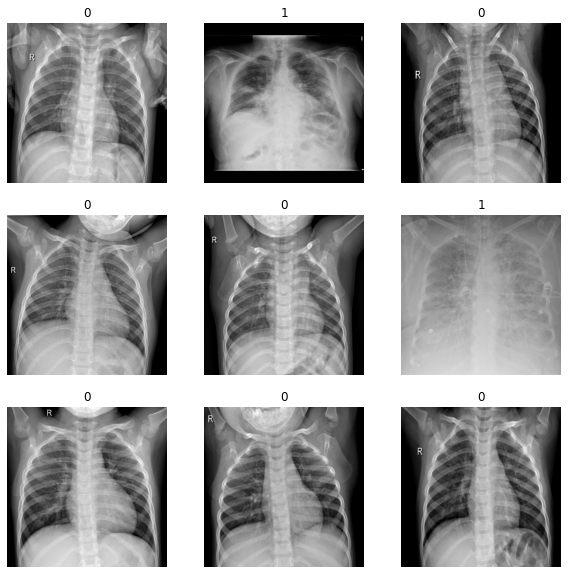

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds_norm = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_norm = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [29]:
base_model=tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=(512,512,3))

base_model.trainable = False
learnRatio = 100.0
L = len(base_model.layers)
fromL = int(learnRatio * L / 100.0)
for layer in base_model.layers[L - fromL:]:
    layer.trainable = True

model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation="sigmoid")
    ])
model.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['binary_accuracy'])

In [31]:
history=model.fit(
  train_ds_norm,
  validation_data=validation_ds_norm,
  epochs=20,
  batch_size=batch_size
)
test_loss, test_acc = model.evaluate(test_ds_norm, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/20
8/8 [==============================] - 10s 1s/step - loss: 0.5845 - binary_accuracy: 0.8320 - val_loss: 0.5522 - val_binary_accuracy: 0.8906
Epoch 2/20
8/8 [==============================] - 10s 1s/step - loss: 0.5608 - binary_accuracy: 0.8125 - val_loss: 0.5485 - val_binary_accuracy: 0.9688
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 0.5746 - binary_accuracy: 0.8086 - val_loss: 0.5325 - val_binary_accuracy: 0.8906
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 0.5532 - binary_accuracy: 0.8125 - val_loss: 0.5229 - val_binary_accuracy: 0.8906
Epoch 5/20
8/8 [==============================] - 10s 1s/step - loss: 0.5457 - binary_accuracy: 0.8203 - val_loss: 0.5191 - val_binary_accuracy: 0.9531
Epoch 6/20
8/8 [==============================] - 10s 1s/step - loss: 0.5334 - binary_accuracy: 0.8516 - val_loss: 0.5100 - val_binary_accuracy: 0.9531
Epoch 7/20
8/8 [==============================] - 10s 1s/step - loss: 0.5172 - binary_ac

In [41]:
test_labels = np.concatenate([y for x, y in test_ds_norm], axis=0)

predictions = model.predict(test_ds_norm)

score = predictions[0]
print(
    "This image is %.2f percent Normal and %.2f percent Covid."
    % (100 * (1 - score), 100 * score)
)
#logit=model.predict(test_ds_norm)
#predicted=predictions.argmax(axis=-1)

#predicted = tf.round(tf.nn.sigmoid(logit))
predicted = tf.round(predictions)
#logit
#tf.keras.metrics.confusion_matrix(test_labels, predictions)

This image is 100.00 percent Normal and 0.00 percent Covid.


In [31]:
base_model2=tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',input_shape=(512,512,3))

base_model2.trainable = False
learnRatio = 100.0
L = len(base_model2.layers)
fromL = int(learnRatio * L / 100.0)
for layer in base_model2.layers[L - fromL:]:
    layer.trainable = True

model2 = tf.keras.Sequential([
      base_model2,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation="sigmoid")
    ])
model2.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['binary_accuracy'])
history2=model2.fit(
  train_ds_norm,
  validation_data=validation_ds_norm,
  epochs=20,
  batch_size=batch_size
)
test_loss, test_acc = model2.evaluate(test_ds_norm, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/20
8/8 [==============================] - 14s 970ms/step - loss: 0.6198 - binary_accuracy: 0.6641 - val_loss: 0.5693 - val_binary_accuracy: 0.8906
Epoch 2/20
8/8 [==============================] - 7s 805ms/step - loss: 0.5373 - binary_accuracy: 0.7500 - val_loss: 0.4813 - val_binary_accuracy: 0.8906
Epoch 3/20
8/8 [==============================] - 7s 802ms/step - loss: 0.4232 - binary_accuracy: 0.9062 - val_loss: 0.4436 - val_binary_accuracy: 0.9688
Epoch 4/20
8/8 [==============================] - 7s 777ms/step - loss: 0.3533 - binary_accuracy: 0.9609 - val_loss: 0.4002 - val_binary_accuracy: 0.9688
Epoch 5/20
8/8 [==============================] - 7s 761ms/step - loss: 0.3033 - binary_accuracy: 0.9805 - val_loss: 0.3610 - val_binary_accuracy: 0.9844
Epoch 6/20
8/8 [==============================] - 7s 748ms/step - loss: 0.2682 - binary_accuracy: 0.9844 - val_loss: 0.3369 - val_binary_accuracy: 0.9844
Epoch 7/20
8/8 [==============================] - 7s 746ms/step - loss: 0.2

In [63]:
#!pip install plotly
import plotly.express as px
import pandas as pd
def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    df = pd.DataFrame(history.history)
    df['epoches']=df.index+1
    fig=px.line(df,x="epoches",y=["binary_accuracy","val_binary_accuracy","loss","val_loss"],title='Training and validation accuracy + loss')
    fig.show()
    #fig=px.line(df,x="epoches",y=["loss","val_loss"],title='Training and validation loss')
    #fig.show()



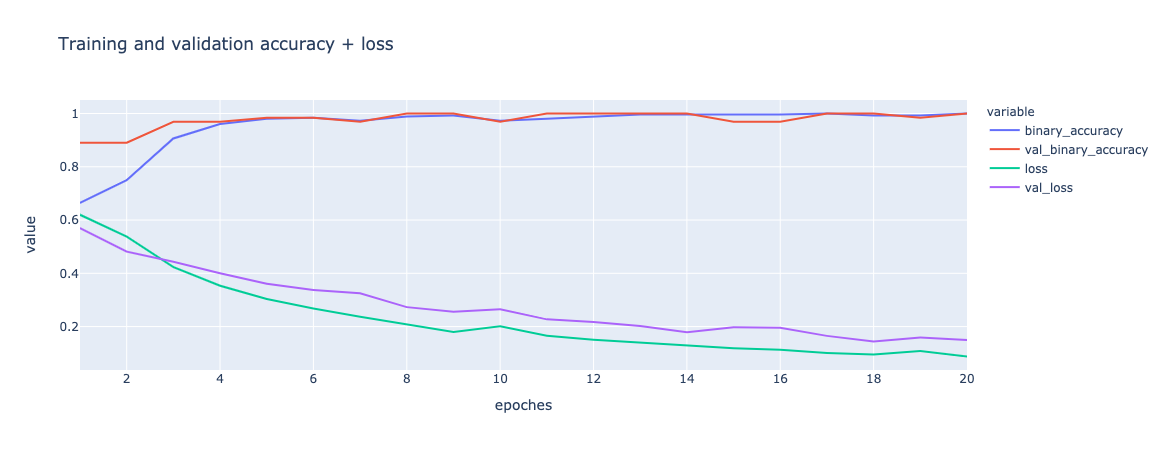

In [64]:
plot_train_curve(history2)

In [12]:
base_model3=tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',input_shape=(512,512,3))

base_model3.trainable = False
learnRatio = 100.0
L = len(base_model3.layers)
fromL = int(learnRatio * L / 100.0)
for layer in base_model3.layers[L - fromL:]:
    layer.trainable = True

model3 = tf.keras.Sequential([
      base_model3,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation="sigmoid")
    ])
model3.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['binary_accuracy'])

ds_norm = train_ds_norm.concatenate(validation_ds_norm)
history3=model3.fit(
  ds_norm,
  #validation_data=validation_ds_norm,
  epochs=50,
  batch_size=batch_size
)
test_loss, test_acc = model3.evaluate(test_ds_norm, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/50
10/10 [==============================] - 12s 599ms/step - loss: 0.7235 - binary_accuracy: 0.5156
Epoch 2/50
10/10 [==============================] - 7s 619ms/step - loss: 0.5604 - binary_accuracy: 0.7281
Epoch 3/50
10/10 [==============================] - 7s 631ms/step - loss: 0.4475 - binary_accuracy: 0.8969
Epoch 4/50
10/10 [==============================] - 7s 636ms/step - loss: 0.3785 - binary_accuracy: 0.9594
Epoch 5/50
10/10 [==============================] - 7s 635ms/step - loss: 0.3277 - binary_accuracy: 0.9469
Epoch 6/50
10/10 [==============================] - 7s 608ms/step - loss: 0.2717 - binary_accuracy: 0.9750
Epoch 7/50
10/10 [==============================] - 7s 599ms/step - loss: 0.2389 - binary_accuracy: 0.9750
Epoch 8/50
10/10 [==============================] - 7s 591ms/step - loss: 0.2133 - binary_accuracy: 0.9875
Epoch 9/50
10/10 [==============================] - 7s 589ms/step - loss: 0.1962 - binary_accuracy: 0.9781
Epoch 10/50
10/10 [=================

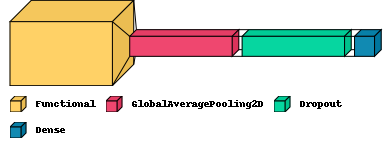

In [25]:
#!pip install visualkeras
import visualkeras
visualkeras.layered_view(model3, legend=True,to_file='transfer.png')

In [24]:
visualkeras.layered_view(base_model3, legend=True,to_file='dense121.png')

In [23]:
visualkeras.layered_view(base_model3, legend=True, one_dim_orientation='x')